# Trabalho Final
Neste trabalho, vamos buscar o reconhecimento dos dígitos da Linguagem de Sinais. Para tal, vamos nos utilizar de Modelos conhecidos de Deep Learning e também nos aventurar na criação de próprios.

------

## Imports

In [ ]:
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

In [20]:
import os
import numpy as np
from random import sample, seed
seed(42)
np.random.seed(42)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,15) # Make the figures a bit bigger

# Keras imports
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout, GlobalAveragePooling2D, Dense, Flatten
from keras.models import Model
from keras.utils import np_utils
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input, decode_predictions

import inf619utils

# Dataset
O dataset é composto por 10 classes (dígitos de 0 a 9) com aproximadamente 205 imagens por classe. 
O conjunto foi dividido em 60% para treinamento, 15% para validação e 20% para teste.
As imagens estão divididas em blocos por classe.

** IMPORTANTE NÃO ALTERAR O NOME/LOCAL DAS IMAGENS** 

In [3]:
keras_model_file = 'keras_mobilenet.h5'

datasetDir = "./Dataset"
datasetDirSplitted = "./DatasetSplitted"
nbClasses = 10
input_shape = (224,224,3)
input_size = (224,224)

train_files = {}
val_files = {}
test_files = {}

train_files, val_files, test_files = inf619utils.splitData(datasetDir, nbClasses)

In [4]:
#plot the images from imgList
def plotImagesFromBatch(imgList):
    for i in range(len(imgList)):
        plotImage(imgList[i])


# Se quiser visualizar algum bloco de imagens, descomentar as linhas abaixo
# inf619utils.plotImages(val_files)
# inf619utils.plotImages(train_files)
# inf619utils.plotImages(test_files)

## Definição do modelo 

In [4]:
model = MobileNet(input_shape=input_shape, classes=nbClasses, include_top=False)
#model.summary()


# Modificação do modelo 

In [5]:
# Escolher a camada que será o ponto de partida 
x = model.output

#print([layer.name for layer in squeezeNetModel.layers])
#print("\n\nFreeze layers up until ", squeezeNetModel.layers[-20].name)

for layer in model.layers:
    layer.trainable = True#        layer.trainable = False

x = Flatten()(x)
x = Dense(10, activation='softmax')(x)


# Não se esqueça de definir o nome modelo, onde baseSqueezeNetModel 
# é o modelo base da Squeeze que vc definiu ali em cima
model = Model(model.inputs, x, name='mobilenet_new_adam')
#model2 = Model(squeezeNetModel.inputs, x, name='squeezenet_new_adadelta')
#model3 = Model(squeezeNetModel.inputs, x, name='squeezenet_new_sgd')

# Treinamento do Modelo

In [6]:
#Definir tamanho do batch e número de épocas
batch_size = 24
epochs = 30

In [7]:
from keras.optimizers import SGD, Adam
#Compile o modelo
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

import keras.callbacks as callbacks

tbCallBack = callbacks.TensorBoard(log_dir = "./logs_mobilenet")
tbEarly = callbacks.EarlyStopping(monitor='val_acc',min_delta=0,patience=3,verbose=0, mode='auto')
tbEarly100 = callbacks.EarlyStopping(monitor='acc', min_delta=0.0001, patience=3, mode='max')
tbModelChk = callbacks.ModelCheckpoint('.modelmobilenet_weights.hdf5', save_best_only=True, monitor='val_acc', mode='max')


In [8]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        datasetDirSplitted + '\\train',
        target_size=input_size,
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        datasetDirSplitted + '\\val',
        target_size=input_size,
        batch_size=batch_size,
        class_mode='categorical')

Found 1242 images belonging to 10 classes.
Found 309 images belonging to 10 classes.


In [9]:
#Fit nos dados
#Fit nos dados
hist = model.fit_generator(train_generator, 
                    steps_per_epoch= int(1242/batch_size), 
                    epochs = epochs,
                    validation_data = validation_generator,  
                    validation_steps = int(309/batch_size),
                    callbacks=[tbCallBack, tbEarly, tbEarly100, tbModelChk])

Epoch 1/30
51/51 [==============================] - 124s 2s/step - loss: 3.0517 - acc: 0.2247 - val_loss: 2.1648 - val_acc: 0.3924
Epoch 2/30
51/51 [==============================] - 113s 2s/step - loss: 1.6997 - acc: 0.4599 - val_loss: 1.5302 - val_acc: 0.5439
Epoch 3/30
51/51 [==============================] - 112s 2s/step - loss: 1.1599 - acc: 0.6100 - val_loss: 0.9839 - val_acc: 0.6632
Epoch 4/30
51/51 [==============================] - 112s 2s/step - loss: 0.8837 - acc: 0.7072 - val_loss: 0.7540 - val_acc: 0.7404
Epoch 5/30
51/51 [==============================] - 112s 2s/step - loss: 0.6620 - acc: 0.7767 - val_loss: 0.7736 - val_acc: 0.7614
Epoch 6/30
51/51 [==============================] - 112s 2s/step - loss: 0.5997 - acc: 0.7922 - val_loss: 0.7237 - val_acc: 0.7719
Epoch 7/30
51/51 [==============================] - 112s 2s/step - loss: 0.4634 - acc: 0.8331 - val_loss: 0.4851 - val_acc: 0.8351
Epoch 8/30
51/51 [==============================] - 112s 2s/step - loss: 0.3660 - a

In [10]:
model.save(keras_model_file)

In [ ]:
del model

# Aplicação do Modelo no Conjunto de Testes

In [5]:
# Load Best weights saved
from keras.utils.generic_utils import CustomObjectScope
from keras.applications.mobilenet import DepthwiseConv2D, relu6
from keras.models import load_model

with CustomObjectScope({'relu6': relu6,'DepthwiseConv2D': DepthwiseConv2D}):
    model = load_model(keras_model_file)

In [6]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        datasetDirSplitted + '\\test',
        target_size=input_size,
        class_mode='categorical',
        shuffle=None)

Found 511 images belonging to 10 classes.


In [18]:
#Criação do generator p/ o conjunto de teste

#Teste
metrics = model.evaluate_generator(test_generator)

print("Test Loss MobileNet---> ", metrics[0])
print("Test Accuracy MobileNet---> ", metrics[1])    #Test is balanced, so Acc is normalized

Test Loss MobileNet--->  0.26169243418482185
Test Accuracy MobileNet--->  0.9138943252031584


# Gerar matrix de confusão

In [8]:
predictions = model.predict_generator(test_generator)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

In [9]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())   

In [10]:
from sklearn.metrics import classification_report

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report) 

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        51
           1       0.91      0.96      0.93        51
           2       0.82      0.90      0.86        51
           3       0.96      0.92      0.94        51
           4       0.87      0.94      0.91        51
           5       0.98      1.00      0.99        51
           6       0.93      0.78      0.85        51
           7       0.82      0.92      0.87        51
           8       0.90      0.87      0.88        52
           9       1.00      0.84      0.91        51

   micro avg       0.91      0.91      0.91       511
   macro avg       0.92      0.91      0.91       511
weighted avg       0.92      0.91      0.91       511



In [11]:
from sklearn.metrics import confusion_matrix

confusion_matrix(true_classes, predicted_classes)

array([[51,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 49,  2,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  4, 46,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  3, 47,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 48,  0,  2,  1,  0,  0],
       [ 0,  0,  0,  0,  0, 51,  0,  0,  0,  0],
       [ 0,  0,  3,  0,  5,  0, 40,  3,  0,  0],
       [ 0,  1,  0,  1,  0,  0,  0, 47,  2,  0],
       [ 1,  0,  1,  1,  1,  0,  0,  3, 45,  0],
       [ 0,  0,  1,  0,  1,  0,  0,  3,  3, 43]], dtype=int64)

Classification report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        51
           1       0.91      0.96      0.93        51
           2       0.82      0.90      0.86        51
           3       0.96      0.92      0.94        51
           4       0.87      0.94      0.91        51
           5       0.98      1.00      0.99        51
           6       0.93      0.78      0.85        51
           7       0.82      0.92      0.87        51
           8       0.90      0.87      0.88        52
           9       1.00      0.84      0.91        51

   micro avg       0.91      0.91      0.91       511
   macro avg       0.92      0.91      0.91       511
weighted avg       0.92      0.91      0.91       511

Normalized confusion matrix
[[100.     0.     0.     0.     0.     0.     0.     0.     0.     0.  ]
 [  0.    96.08   3.92   0.     0.     0.     0.     0.     0.     0.  ]
 [  0.     7.84  90.2    0.     0.     0.    

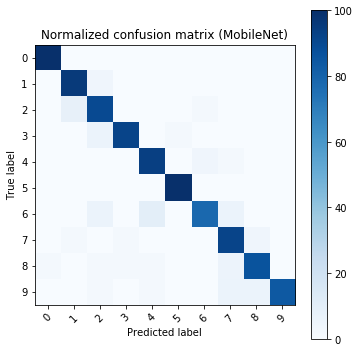

In [26]:
plot_confusion(true_classes, predicted_classes, "MobileNet")

# Salvar modelo TensorflowJS (Linux)

In [ ]:
#import tensorflowjs as tfjs
#tfjs.converters.save_keras_model(model, tfjs_target_dir)

# Salvar modelo TensorflowLite (Linux)

In [ ]:
#from tensorflow.contrib import lite

#converter = lite.TocoConverter.from_keras_model_file(keras_model_file)
#tflite_model = converter.convert()
#open("resnet.tflite", "wb").write(tflite_model)